In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from matplotlib import font_manager, rc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
font_path = "c:\WINDOWS\Fonts\GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', size=8) 

# 이상치 탐지 함수 (IQR)

In [2]:
def findOutliers(dataframe: pd.DataFrame, col : str) -> tuple:
    '''
    해당 DataFrame의 칼럼의 이상치에 해당하는 데이터 프레임과 개수를 알려드립니다.
    '''
    q1 = dataframe[col].quantile(0.25)
    q3 = dataframe[col].quantile(0.75)
    
    iqr = q3-q1
    minimum = q1 - (1.5) * iqr
    maximum = q3 + (1.5) * iqr

    outliers = dataframe[(dataframe[col] < minimum) | (dataframe[col] > maximum)]

    return (outliers[[col]],len(outliers))

In [3]:
dataframe = pd.read_csv(r'C:\Users\hyssk\AICE_\open\train.csv')
dataframe.drop(columns='ID',inplace=True)
dataframe

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [4]:
dataframe['근로기간']=dataframe['근로기간'].replace('1 years','1 year')
dataframe['근로기간']=dataframe['근로기간'].replace('3','3 years')
dataframe['근로기간']=dataframe['근로기간'].replace('<1 year','< 1 year')
dataframe['근로기간']=dataframe['근로기간'].replace('10+years','10+ years')
dataframe['근로기간'].value_counts()

근로기간
10+ years    32481
2 years       8450
< 1 year      8144
3 years       7670
1 year        6305
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
Name: count, dtype: int64

# 범주형 데이터 전처리하기 (Pandas.factorize())

In [5]:
categorical_columns = dataframe.select_dtypes('object').columns
categorical_columns # 범주형 칼럼명들의 리스트

Index(['대출기간', '근로기간', '주택소유상태', '대출목적', '대출등급'], dtype='object')

In [6]:
dataframe[['대출기간']] = pd.factorize(dataframe['대출기간'])[0].reshape(-1,1)
dataframe[['대출기간']]

,대출기간
0,0
1,1
2,0
3,0
4,1
...,...
96289,0
96290,1
96291,0
96292,0


In [7]:
dataframe['대출기간'].value_counts()

대출기간
0    64479
1    31815
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataframe['근로기간'] = le.fit_transform(dataframe['근로기간'])
dataframe[['근로기간']]


,근로기간
0,6
1,1
2,5
3,8
4,11
...,...
96289,1
96290,1
96291,0
96292,5


In [9]:
dataframe

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,0,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,1,1,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,0,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,0,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,1,11,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,1,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,1,1,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,0,0,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,0,5,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [10]:
dataframe['주택소유상태'].values

array(['RENT', 'MORTGAGE', 'MORTGAGE', ..., 'MORTGAGE', 'MORTGAGE',
       'RENT'], dtype=object)

In [11]:
from sklearn.preprocessing import OneHotEncoder

oh=OneHotEncoder()
encoder = oh.fit_transform(dataframe[['주택소유상태']]).toarray()
print(f'OneHotEncoder 이해하기:',type(oh.fit_transform(dataframe[['주택소유상태']])))
print(f'OneHotEncoder.fit_transform 자료 \n',oh.fit_transform(dataframe[['주택소유상태']]).toarray())
print(f'OneHotEncode된 칼럼명들 : {oh.get_feature_names_out()}')
print(f'OneHotEncode 하려고하는 칼럼의 수준: {oh.categories_}')
print(f'OneHotEncoder의 feature_names_in_(어떤 칼럼이 인코딩되기 위해 입력됐는가?): {oh.feature_names_in_}')

OneHotEncoder 이해하기: <class 'scipy.sparse._csr.csr_matrix'>
OneHotEncoder.fit_transform 자료 
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
OneHotEncode된 칼럼명들 : ['주택소유상태_ANY' '주택소유상태_MORTGAGE' '주택소유상태_OWN' '주택소유상태_RENT']
OneHotEncode 하려고하는 칼럼의 수준: [array(['ANY', 'MORTGAGE', 'OWN', 'RENT'], dtype=object)]
OneHotEncoder의 feature_names_in_(어떤 칼럼이 인코딩되기 위해 입력됐는가?): ['주택소유상태']


In [12]:
dataframe[['주택소유상태']]

,주택소유상태
0,RENT
1,MORTGAGE
2,MORTGAGE
3,MORTGAGE
4,RENT
...,...
96289,MORTGAGE
96290,MORTGAGE
96291,MORTGAGE
96292,MORTGAGE


In [13]:
encoded_state=pd.DataFrame(encoder, columns=oh.get_feature_names_out())
dataframe = pd.concat([dataframe,encoded_state],axis=1)
dataframe.drop(columns='주택소유상태',inplace=True)
dataframe

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,주택소유상태_ANY,주택소유상태_MORTGAGE,주택소유상태_OWN,주택소유상태_RENT
0,12480000,0,6,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.0,0.0,0.0,1.0
1,14400000,1,1,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,0.0,1.0,0.0,0.0
2,12000000,0,5,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,0.0,1.0,0.0,0.0
3,14400000,0,8,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C,0.0,1.0,0.0,0.0
4,18000000,1,11,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,1,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C,0.0,1.0,0.0,0.0
96290,28800000,1,1,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E,0.0,1.0,0.0,0.0
96291,14400000,0,0,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A,0.0,1.0,0.0,0.0
96292,15600000,0,5,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D,0.0,1.0,0.0,0.0


In [14]:
dataframe[['대출등급']].value_counts()

대출등급
B       28817
C       27623
A       16772
D       13354
E        7354
F        1954
G         420
Name: count, dtype: int64

In [15]:
onehot_columns = ['대출목적'] # 원핫인코딩할 칼럼

ohe = OneHotEncoder()
for col in onehot_columns:
   array=ohe.fit_transform(dataframe[[col]]).toarray()
   print(f'[{col}]: \n{array} 입니다. \n')
   cols=pd.DataFrame(array,columns=ohe.get_feature_names_out())
   dataframe=pd.concat([dataframe,cols],axis=1)
dataframe.drop(columns=['대출목적'],inplace=True)
dataframe

[대출목적]: 
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 입니다. 



,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,12480000,0,6,72000000,18.90,15,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14400000,1,1,130800000,22.33,21,0,373572,234060.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,12000000,0,5,96000000,8.60,14,0,928644,151944.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14400000,0,8,132000000,15.09,15,0,325824,153108.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18000000,1,11,71736000,25.39,19,0,228540,148956.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,1,210000000,9.33,33,0,974580,492168.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,28800000,1,1,132000000,5.16,25,0,583728,855084.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96291,14400000,0,0,84000000,11.24,22,0,1489128,241236.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,15600000,0,5,66330000,17.30,21,2,1378368,818076.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 대출등급 y 정답값 Label Encoder 하기

In [16]:
le = LabelEncoder()
dataframe['대출등급'] = le.fit_transform(dataframe['대출등급']).reshape(-1,1)
dataframe[['대출등급']]

,대출등급
0,2
1,1
2,0
3,2
4,1
...,...
96289,2
96290,4
96291,0
96292,3


# 수치형 데이터칼럼 분포 확인하기. 어느 것도 정규분포를 따르는 것이 없음`

<Figure size 640x480 with 0 Axes>

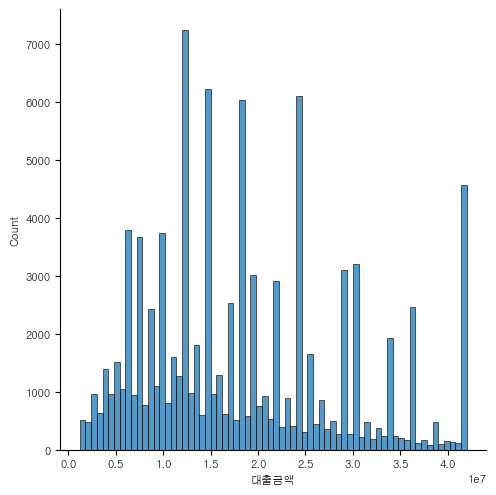

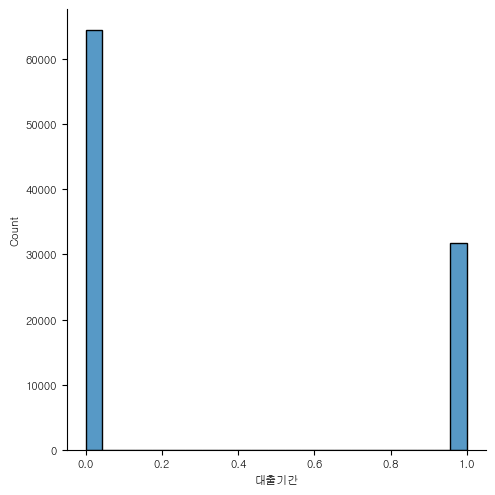

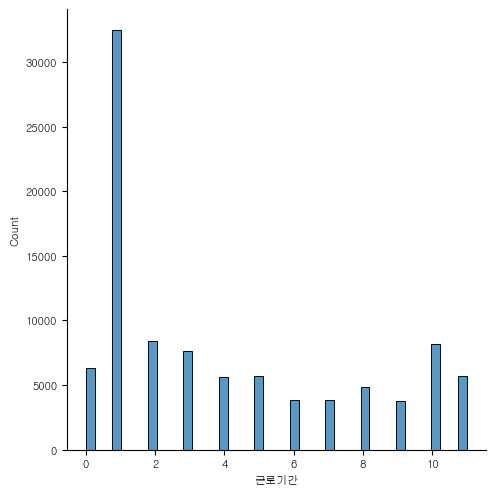

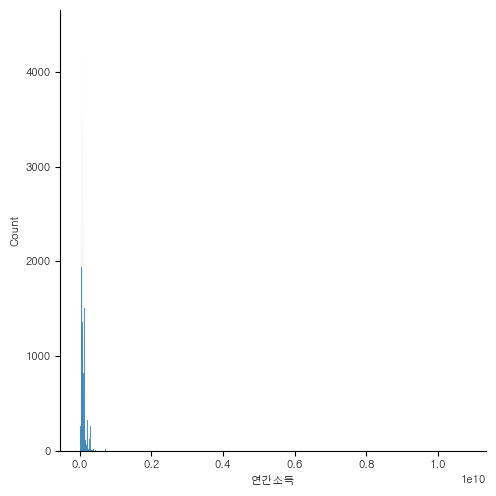

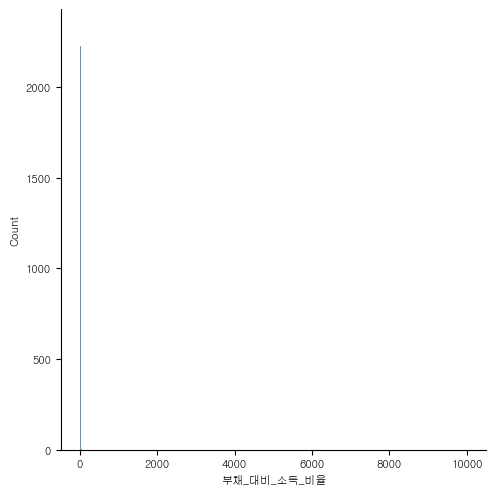

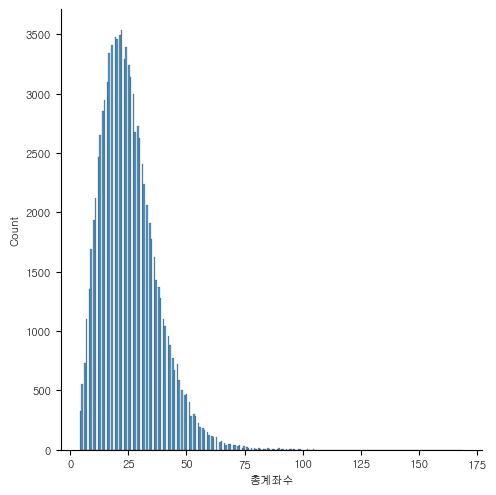

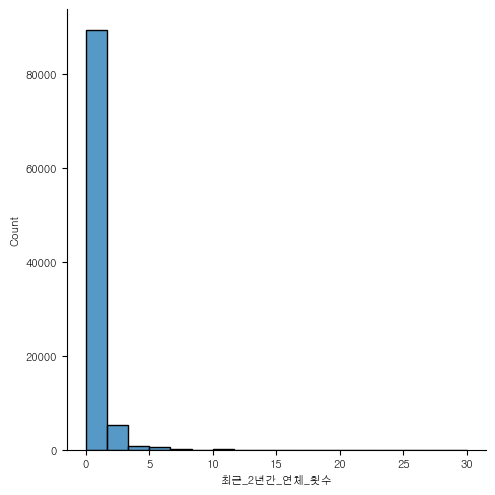

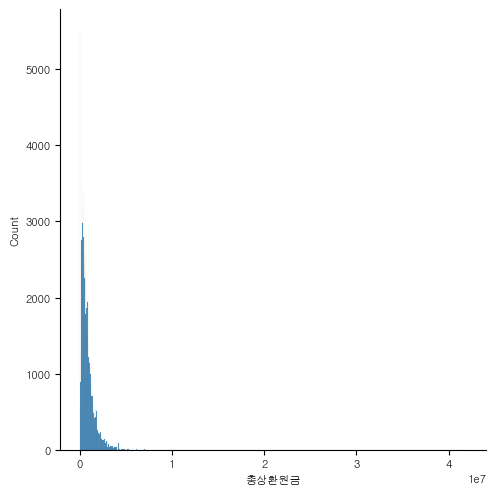

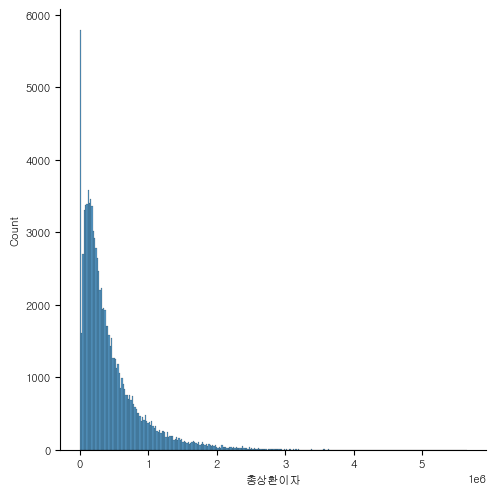

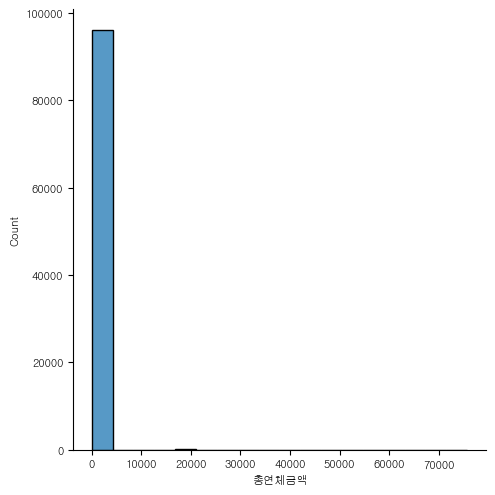

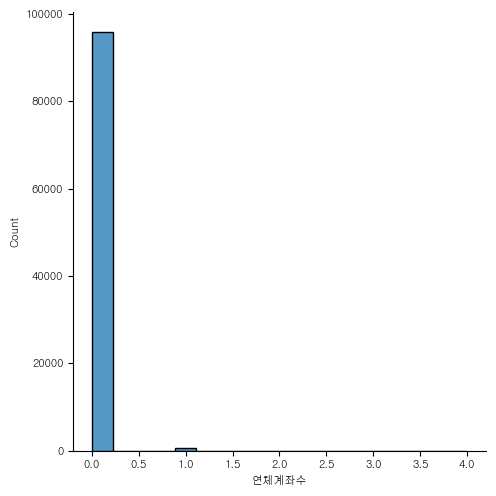

In [17]:
plt.figure()
for col in ['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총상환이자','총연체금액','연체계좌수']:
    sns.displot(dataframe,x=col)
plt.show()

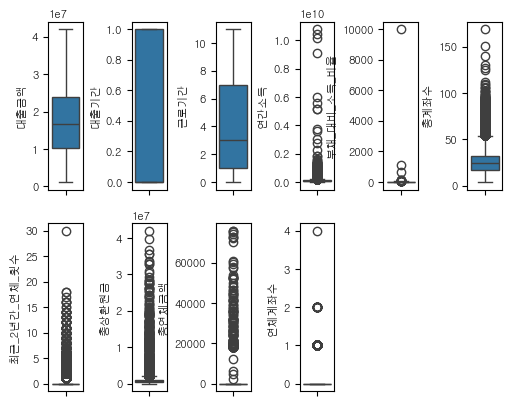

In [18]:
# 적용하기 전 boxplot
plt.figure()
for i, col in enumerate(['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총연체금액','연체계좌수']):
    plt.subplot(2,12,(i+1)*2)
    sns.boxplot(dataframe,y=col)
plt.show()

In [19]:
from sklearn.preprocessing import RobustScaler

rs=RobustScaler()
for col in ['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총상환이자','총연체금액','연체계좌수']:
    dataframe[col] = rs.fit_transform(dataframe[[col]])
dataframe

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,-0.313043,0.0,0.500000,-0.108696,0.012413,-0.600000,0.0,-0.799589,-0.658871,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.173913,1.0,-0.333333,0.956522,0.278510,-0.200000,0.0,-0.299830,-0.121543,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.347826,0.0,0.333333,0.326087,-0.786656,-0.666667,0.0,0.442737,-0.310055,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.173913,0.0,0.833333,0.978261,-0.283165,-0.600000,0.0,-0.363706,-0.307383,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.086957,1.0,1.333333,-0.113478,0.515904,-0.333333,0.0,-0.493852,-0.316915,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,-0.173913,0.0,-0.333333,2.391304,-0.730023,0.600000,0.0,0.504190,0.470992,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,0.869565,1.0,-0.333333,0.978261,-1.053530,0.066667,0.0,-0.018686,1.304132,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96291,-0.173913,0.0,-0.500000,0.108696,-0.581846,-0.133333,0.0,1.192545,-0.105069,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,-0.086957,0.0,0.333333,-0.211413,-0.111715,-0.200000,2.0,1.044372,1.219174,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


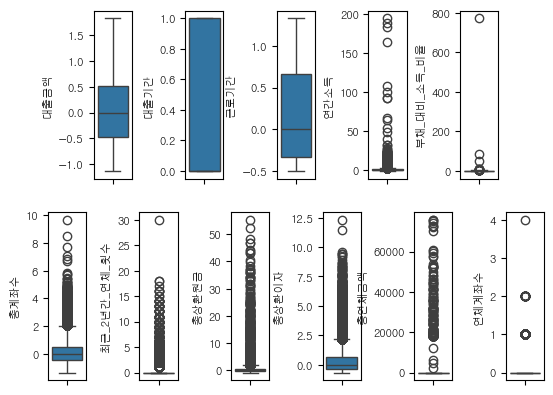

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,-0.313043,0.0,0.500000,-0.108696,0.012413,-0.600000,0.0,-0.799589,-0.658871,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.173913,1.0,-0.333333,0.956522,0.278510,-0.200000,0.0,-0.299830,-0.121543,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.347826,0.0,0.333333,0.326087,-0.786656,-0.666667,0.0,0.442737,-0.310055,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.173913,0.0,0.833333,0.978261,-0.283165,-0.600000,0.0,-0.363706,-0.307383,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.086957,1.0,1.333333,-0.113478,0.515904,-0.333333,0.0,-0.493852,-0.316915,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,-0.173913,0.0,-0.333333,2.391304,-0.730023,0.600000,0.0,0.504190,0.470992,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,0.869565,1.0,-0.333333,0.978261,-1.053530,0.066667,0.0,-0.018686,1.304132,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96291,-0.173913,0.0,-0.500000,0.108696,-0.581846,-0.133333,0.0,1.192545,-0.105069,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,-0.086957,0.0,0.333333,-0.211413,-0.111715,-0.200000,2.0,1.044372,1.219174,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
plt.figure() # 적용한 뒤 boxplot
for i, col in enumerate(['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총상환이자','총연체금액','연체계좌수']):
    plt.subplot(2,11,(i+1)*2)
    sns.boxplot(dataframe,y=col)
plt.show()
dataframe


# 이상치 처리에 대한 고찰

Boxplot 해보면 많은 칼럼이 이상치라고 뜹니다.

정말 시각화된 정보가 이상치인지 확인해봅시다.



해당 칼럼 [대출금액] 의 이상치 개수: 0개
해당 칼럼 [대출기간] 의 이상치 개수: 0개
해당 칼럼 [근로기간] 의 이상치 개수: 0개
해당 칼럼 [연간소득] 의 이상치 개수: 4347개
해당 칼럼 [부채_대비_소득_비율] 의 이상치 개수: 30개
해당 칼럼 [총계좌수] 의 이상치 개수: 2097개
해당 칼럼 [최근_2년간_연체_횟수] 의 이상치 개수: 19902개
해당 칼럼 [총상환원금] 의 이상치 개수: 5196개
해당 칼럼 [총연체금액] 의 이상치 개수: 181개
해당 칼럼 [연체계좌수] 의 이상치 개수: 532개


,최근_2년간_연체_횟수
11,1.0
13,1.0
27,9.0
29,1.0
31,11.0
...,...
96266,2.0
96270,1.0
96277,1.0
96288,10.0


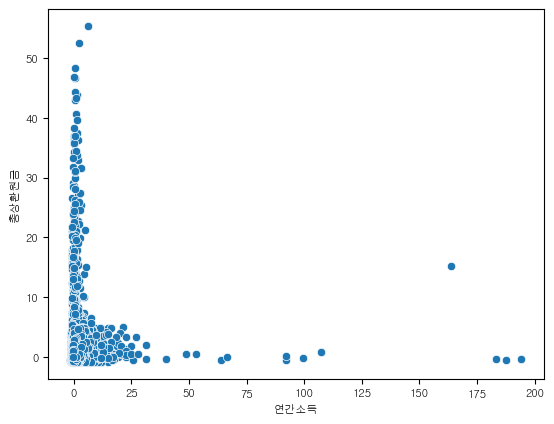

In [22]:
for i in ['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총연체금액','연체계좌수']:
    outliers, length = findOutliers(dataframe,i)
    print(f'해당 칼럼 [{i}] 의 이상치 개수: {length}개')

dataframe[['연간소득','최근_2년간_연체_횟수','총상환원금','연체계좌수']].describe()
plt.figure()
sns.scatterplot(dataframe,x='연간소득',y='총상환원금')
outliers, length = findOutliers(dataframe,'최근_2년간_연체_횟수')
outliers

최근_2년간_연체_횟수 outlier에 1도 포함된 것을 보니 0을 가진 값이 너무 많기에 1도 이상치라고 탐지 한 것 같다.

따라서 최근_2년간_연체_횟수 칼럼은 이상치 변경을 진행하지 않을 것이다.

또한 연간소득과 총상환원금 Scatterplot을 그려보았을 때, 이상치가 크게 튀는 4개의 관측치가 존재했다.

이는 이후 모델 성능에 방해가 될 요소라고 생각되기에 데이터를 삭제를 통해서 특성을 없애기로했다.



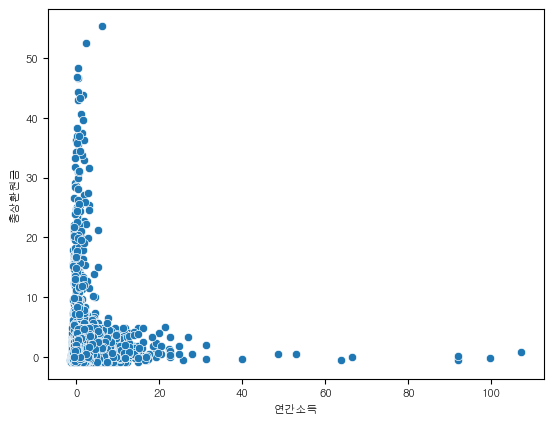

In [23]:
delete_index=dataframe[dataframe['연간소득'] > 150].index

dataframe.drop(index=delete_index,inplace=True)

plt.figure() # 삭제되었는지 확인
sns.scatterplot(dataframe,x='연간소득',y='총상환원금')
plt.show()

# 데이터 분리 

In [24]:
X = dataframe.drop(columns='대출등급')
y = dataframe.pop('대출등급')
y

0        2
1        1
2        0
3        2
4        1
        ..
96289    2
96290    4
96291    0
96292    3
96293    2
Name: 대출등급, Length: 96290, dtype: int32

# 데이터 학습 / 검증 분할 및 학습 및 검증 평가

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7, test_size=0.3,random_state=42, stratify=y)

etc=ExtraTreeClassifier(random_state=42)
ada=AdaBoostClassifier(random_state=42)
rfc=RandomForestClassifier(random_state=42)
dtc=DecisionTreeClassifier(random_state=42)

etc.fit(X_train,y_train) # 학습하기
ada.fit(X_train,y_train) 
rfc.fit(X_train,y_train)
dtc.fit(X_train,y_train)

print(f'학습 결과: {etc.score(X_train,y_train)*100:.3f} %, 검증 결과: {etc.score(X_test,y_test)*100:.3f} %')
print(f'학습 결과: {ada.score(X_train,y_train)*100:.3f} %, 검증 결과: {ada.score(X_test,y_test)*100:.3f} %')
print(f'학습 결과: {rfc.score(X_train,y_train)*100:.3f} %, 검증 결과: {rfc.score(X_test,y_test)*100:.3f} %')
print(f'학습 결과: {dtc.score(X_train,y_train)*100:.3f} %, 검증 결과: {dtc.score(X_test,y_test)*100:.3f} %')

학습 결과: 100.000 %, 검증 결과: 41.936 %
학습 결과: 49.766 %, 검증 결과: 50.203 %
학습 결과: 100.000 %, 검증 결과: 76.097 %
학습 결과: 100.000 %, 검증 결과: 82.736 %


In [26]:
low_importances_column = []
for i, importances in enumerate(dtc.feature_importances_):
    print(f'칼럼마다 중요도 {dtc.feature_names_in_[i]} : {importances:.4f}')
    if importances < 0.02:
        low_importances_column.append(dtc.feature_names_in_[i])
print(f'중요도 0.02보다 작은 칼럼들: {low_importances_column}')

칼럼마다 중요도 대출금액 : 0.0571
칼럼마다 중요도 대출기간 : 0.0339
칼럼마다 중요도 근로기간 : 0.0141
칼럼마다 중요도 연간소득 : 0.0341
칼럼마다 중요도 부채_대비_소득_비율 : 0.0293
칼럼마다 중요도 총계좌수 : 0.0261
칼럼마다 중요도 최근_2년간_연체_횟수 : 0.0055
칼럼마다 중요도 총상환원금 : 0.4152
칼럼마다 중요도 총상환이자 : 0.3621
칼럼마다 중요도 총연체금액 : 0.0005
칼럼마다 중요도 연체계좌수 : 0.0004
칼럼마다 중요도 주택소유상태_ANY : 0.0000
칼럼마다 중요도 주택소유상태_MORTGAGE : 0.0031
칼럼마다 중요도 주택소유상태_OWN : 0.0023
칼럼마다 중요도 주택소유상태_RENT : 0.0030
칼럼마다 중요도 대출목적_기타 : 0.0018
칼럼마다 중요도 대출목적_부채 통합 : 0.0031
칼럼마다 중요도 대출목적_소규모 사업 : 0.0006
칼럼마다 중요도 대출목적_신용 카드 : 0.0030
칼럼마다 중요도 대출목적_의료 : 0.0007
칼럼마다 중요도 대출목적_이사 : 0.0006
칼럼마다 중요도 대출목적_자동차 : 0.0004
칼럼마다 중요도 대출목적_재생 에너지 : 0.0001
칼럼마다 중요도 대출목적_주요 구매 : 0.0005
칼럼마다 중요도 대출목적_주택 : 0.0006
칼럼마다 중요도 대출목적_주택 개선 : 0.0015
칼럼마다 중요도 대출목적_휴가 : 0.0005
중요도 0.02보다 작은 칼럼들: ['근로기간', '최근_2년간_연체_횟수', '총연체금액', '연체계좌수', '주택소유상태_ANY', '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴

In [27]:
X_train.drop(columns=low_importances_column,inplace=True)
X_test.drop(columns=low_importances_column,inplace=True)
X_train

,대출금액,대출기간,연간소득,부채_대비_소득_비율,총계좌수,총상환원금,총상환이자
42717,0.956522,1.0,-0.326087,0.677269,-0.466667,0.277660,3.343388
84396,-0.800000,0.0,0.000000,0.753297,1.466667,-0.618555,-0.543471
79672,0.013043,1.0,0.413043,-0.817688,0.866667,-0.210300,-0.035647
70252,-0.813043,0.0,0.869565,1.080683,0.733333,-0.315659,-0.108788
90050,-0.347826,1.0,0.108696,0.163693,1.200000,-0.289540,0.530937
...,...,...,...,...,...,...,...
23523,0.521739,1.0,-0.086957,-0.680372,-1.200000,-0.470430,-0.262672
20444,0.434783,1.0,-0.586957,-0.564003,0.466667,0.581744,1.973471
49881,-0.382609,0.0,0.434783,-1.334368,-0.333333,-0.035414,-0.326997
52641,-0.173913,1.0,-0.108696,-0.060512,-0.466667,-0.296828,1.296915


In [36]:
X_test,y_test

(           대출금액  대출기간      연간소득  부채_대비_소득_비율      총계좌수     총상환원금     총상환이자
 71497  0.680435   1.0 -0.282609     0.109387 -0.800000  0.538336  3.943140
 91191 -0.695652   0.0 -0.282609    -0.404965  0.333333 -0.317553 -0.468044
 1288  -0.608696   0.0 -0.717391     0.364624  0.466667  0.002504 -0.153333
 95419 -0.173913   0.0 -0.115217    -0.593483 -0.933333  0.178899 -0.296501
 10764 -0.608696   0.0 -1.016522     1.200155 -0.800000 -0.293216 -0.218815
 ...         ...   ...       ...          ...       ...       ...       ...
 26523 -0.591304   0.0  0.456522     0.700543 -0.333333  0.037388 -0.186419
 1354   1.582609   1.0  0.108696    -0.098526  0.266667 -0.143839  0.329807
 18894 -0.521739   0.0 -0.760870    -0.786656 -0.400000  0.254078 -0.447851
 88428 -0.695652   0.0 -0.152174    -0.749418 -0.666667  1.203718 -0.278788
 69253 -0.260870   0.0  0.543478    -1.099302 -0.733333  0.036875 -0.128871
 
 [28887 rows x 7 columns],
 71497    5
 91191    0
 1288     1
 95419    0
 10764    2

In [37]:
y_test.values

array([5, 0, 1, ..., 0, 1, 1])

# 중요도 낮은 칼럼들을 제거한 뒤, 다시 Feature 학습 진행

In [43]:
dtc.fit(X_train,y_train)
print(f'학습 결과: {(dtc.score(X_train,y_train)*100):.3f} % | 검증 결과: {(dtc.score(X_test,y_test)*100):.3f} %')
print(f'dtc 모델의 예측 결과: \n {dtc.predict(X_test)}\n정답값:\n {y_test.values}')

학습 결과: 100.000 % | 검증 결과: 83.390 %
dtc 모델의 예측 결과: 
 [5 0 1 ... 0 0 1]
정답값:
 [5 0 1 ... 0 1 1]


82.736 % -> 83.390 % : (0.645 %) 향상

In [49]:
from sklearn.metrics import f1_score
macro_prediction = f1_score(y_test,dtc.predict(X_test), average='macro')
print(f'macro_f1_score 점수: {macro_prediction*100:.3f}%')



macro_f1_score 점수: 76.730%
